In [1]:
import os
import gc
import time
import pickle
from pathlib import Path
import numpy as np
import pandas as ps

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_folder = Path('..') / 'data'

In [3]:
with open(str(data_folder / 'processed' / 'train_13.pkl'), 'rb') as f:
    train_df = pickle.load(f)
    
print('Train shapes:', train_df.shape)

Train shapes: (354851, 216)


In [4]:
with open(str(data_folder / 'processed' / 'test_13.pkl'), 'rb') as f:
    test_df = pickle.load(f)

print('Test shapes:', test_df.shape)

Test shapes: (202614, 215)


In [5]:
target = 'CancelFlag'
drop_features = [
    'OrderID', 
    'Date_day', 
    'Date_year',
    'OrderDate_day', 
    'OrderDate_year',
    target,
]
features2use = [f for f in train_df.columns if not any(f.startswith(df) for df in drop_features)]
categorical_features = []

In [6]:
len(features2use)

214

In [7]:
test_df[target] = 0
# train_df = train_df.iloc[:10_000]

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, 
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(
        ax.get_xticklabels(), 
        rotation=45, 
        ha="right",
        rotation_mode="anchor"
    )

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.grid(b=None)
    plt.show(fig)

In [9]:
def make_predictions(folds, 
                     train_dframe,
                     test_dframe,
                     model_params, 
                     features,
                     target,
                     categorical=[],
                     n_estimators=50_000, n_jobs=12, 
                     verbose=10_000, early_stopping_rounds=200):

    X, y = train_dframe[features], train_dframe[target]
    P = test_dframe[features]
    num_folds = folds.n_splits
    
    oof_preds = np.zeros((len(train_dframe), 1))
    predictions = np.zeros((len(test_dframe), 1))
    
    feature_importance = ps.DataFrame.from_dict({
        'feature': features,
        'importance': np.zeros(len(features))
    })
    scores = []
    
    for fold_, (train_idx, valid_idx) in enumerate(folds.split(X, y.values)):
        print()
        print(f'[{time.ctime()}] Fold: {fold_ + 1}/{num_folds}', flush=True)
        
        train_x, train_y = X.iloc[train_idx,:], y.iloc[train_idx]
        valid_x, valid_y = X.iloc[valid_idx,:], y.iloc[valid_idx]
        print('Train & val shapes -', len(train_x), len(valid_y), flush=True)
        
#         pos_weight = np.sum(train_y == 0) / np.sum(train_y == 1)
#         pos_weight *= 1e5
#         print(f'Positive weight - {pos_weight}')
        
        model = lgb.LGBMClassifier(
            **model_params, 
            n_estimators=n_estimators, 
            n_jobs=n_jobs,
#             scale_pos_weight=pos_weight,
#             is_unbalance=True
        )
        model.fit(
            train_x, train_y,
            eval_set=[(train_x, train_y), (valid_x, valid_y)],
            early_stopping_rounds=early_stopping_rounds,
            verbose=verbose,
            categorical_feature=categorical
        )
        feature_importance['importance'] += model.feature_importances_ / num_folds
        
        valid_preds = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1] 
        oof_preds[valid_idx] = valid_preds.reshape(-1, 1)
        
        valid_pred_cls = model.predict(valid_x, num_iteration=model.best_iteration_)
        print()
        print(classification_report(valid_y, valid_pred_cls))
        plot_confusion_matrix(valid_y, valid_pred_cls, classes=[f'not {target}', target], normalize=True)
        scores.append(roc_auc_score(valid_y.values, valid_preds))
        
        test_preds = model.predict_proba(P, num_iteration=model.best_iteration_)[:, 1]
        predictions += test_preds.reshape(-1, 1)
    
    test_dframe[target] = predictions / num_folds
    
    print()
    print(f'Folds score - {np.mean(scores):.6f} +- {np.std(scores):.6f}', flush=True)
    print()
    
    return test_dframe, oof_preds, feature_importance

In [10]:
params = {
#     'num_leaves': 491,
#     'min_child_weight': 0.03454472573214212,
#     'feature_fraction': 0.3797454081646243,
#     'bagging_fraction': 0.4181193142567742,
#     'min_data_in_leaf': 106,
    'objective': 'binary',
    'max_depth': -1,
    'learning_rate': 0.005,
    'boosting_type': 'gbdt',
    'bagging_seed': 11,
    'metric': 'auc',
    'verbosity': -1,
#     'reg_alpha': 0.3899927210061127,
#     'reg_lambda': 0.6485237330340494,
    'random_state': 47,
}
folds = StratifiedKFold(n_splits=7, random_state=2019)
# folds = KFold(n_splits=7, random_state=2019)


[Sat Nov 23 12:35:15 2019] Fold: 1/7
Train & val shapes - 304157 50694
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.879508	valid_1's auc: 0.852471
[2000]	training's auc: 0.900149	valid_1's auc: 0.872423
[3000]	training's auc: 0.914062	valid_1's auc: 0.874985
[4000]	training's auc: 0.92412	valid_1's auc: 0.877562
[5000]	training's auc: 0.932407	valid_1's auc: 0.87843
[6000]	training's auc: 0.939611	valid_1's auc: 0.879043
[7000]	training's auc: 0.945927	valid_1's auc: 0.879807
[8000]	training's auc: 0.951295	valid_1's auc: 0.880672
[9000]	training's auc: 0.956103	valid_1's auc: 0.88124
[10000]	training's auc: 0.960416	valid_1's auc: 0.881245
Early stopping, best iteration is:
[9671]	training's auc: 0.959104	valid_1's auc: 0.881397

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     47297
           1       0.72      0.32      0.44      3397

    accuracy                           0.95     506

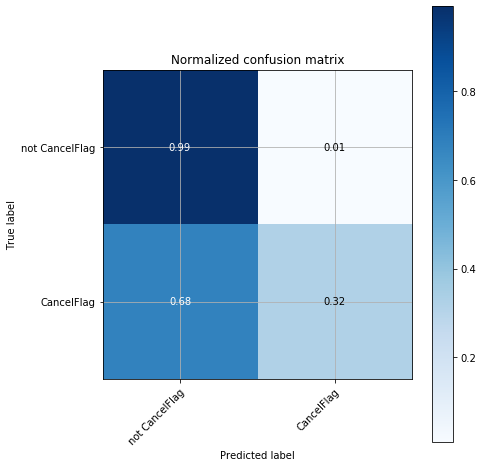


[Sat Nov 23 12:40:25 2019] Fold: 2/7
Train & val shapes - 304157 50694
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.881238	valid_1's auc: 0.865965
[2000]	training's auc: 0.901404	valid_1's auc: 0.878287
[3000]	training's auc: 0.915178	valid_1's auc: 0.883026
[4000]	training's auc: 0.925272	valid_1's auc: 0.885137
[5000]	training's auc: 0.933626	valid_1's auc: 0.886459
[6000]	training's auc: 0.940578	valid_1's auc: 0.887253
[7000]	training's auc: 0.946794	valid_1's auc: 0.88792
[8000]	training's auc: 0.952099	valid_1's auc: 0.888416
[9000]	training's auc: 0.956546	valid_1's auc: 0.888707
[10000]	training's auc: 0.960839	valid_1's auc: 0.889049
[11000]	training's auc: 0.964406	valid_1's auc: 0.889269
[12000]	training's auc: 0.967553	valid_1's auc: 0.889479
[13000]	training's auc: 0.970447	valid_1's auc: 0.889625
Early stopping, best iteration is:
[12850]	training's auc: 0.970014	valid_1's auc: 0.889634

              precision    recall  f1-sco

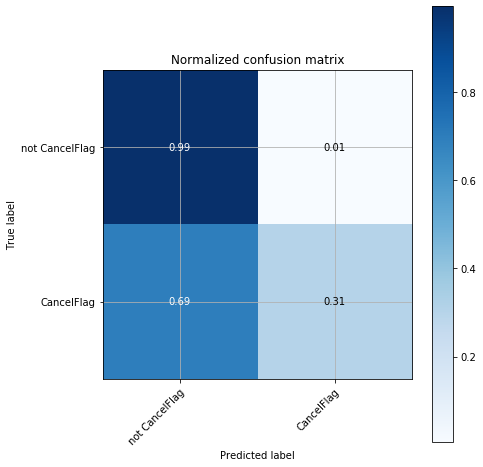


[Sat Nov 23 12:46:54 2019] Fold: 3/7
Train & val shapes - 304157 50694
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.880143	valid_1's auc: 0.865271
Early stopping, best iteration is:
[1008]	training's auc: 0.880353	valid_1's auc: 0.865359

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     47297
           1       0.93      0.16      0.27      3397

    accuracy                           0.94     50694
   macro avg       0.94      0.58      0.62     50694
weighted avg       0.94      0.94      0.92     50694



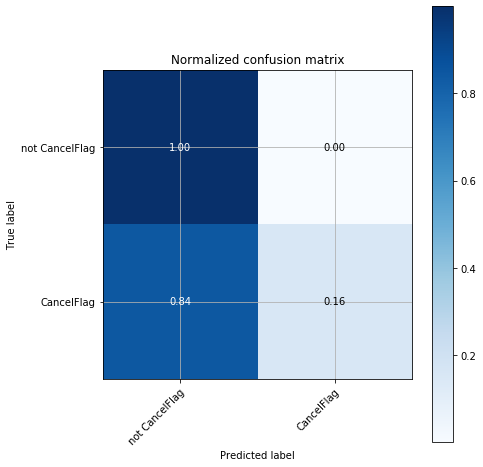


[Sat Nov 23 12:47:57 2019] Fold: 4/7
Train & val shapes - 304158 50693
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.880126	valid_1's auc: 0.873539
[2000]	training's auc: 0.900138	valid_1's auc: 0.887515
[3000]	training's auc: 0.913885	valid_1's auc: 0.891853
[4000]	training's auc: 0.924438	valid_1's auc: 0.894095
[5000]	training's auc: 0.932814	valid_1's auc: 0.895253
[6000]	training's auc: 0.93996	valid_1's auc: 0.896184
[7000]	training's auc: 0.946043	valid_1's auc: 0.896907
[8000]	training's auc: 0.951533	valid_1's auc: 0.897541
[9000]	training's auc: 0.956267	valid_1's auc: 0.8979
[10000]	training's auc: 0.96038	valid_1's auc: 0.898346
[11000]	training's auc: 0.964058	valid_1's auc: 0.898641
[12000]	training's auc: 0.967384	valid_1's auc: 0.898888
[13000]	training's auc: 0.970313	valid_1's auc: 0.899196
[14000]	training's auc: 0.972891	valid_1's auc: 0.899451
[15000]	training's auc: 0.975203	valid_1's auc: 0.899502
Early stopping, best it

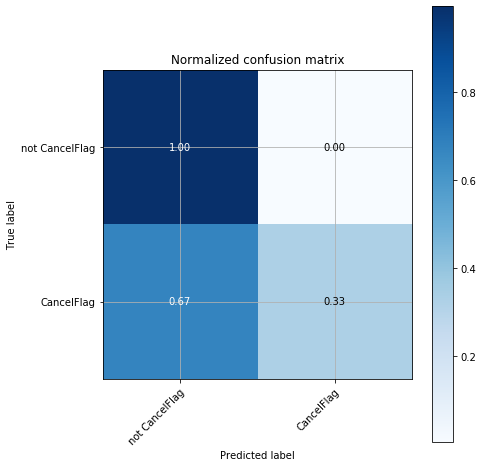


[Sat Nov 23 12:55:15 2019] Fold: 5/7
Train & val shapes - 304159 50692
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[457]	training's auc: 0.858531	valid_1's auc: 0.848597

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     47296
           1       0.98      0.11      0.21      3396

    accuracy                           0.94     50692
   macro avg       0.96      0.56      0.59     50692
weighted avg       0.94      0.94      0.92     50692



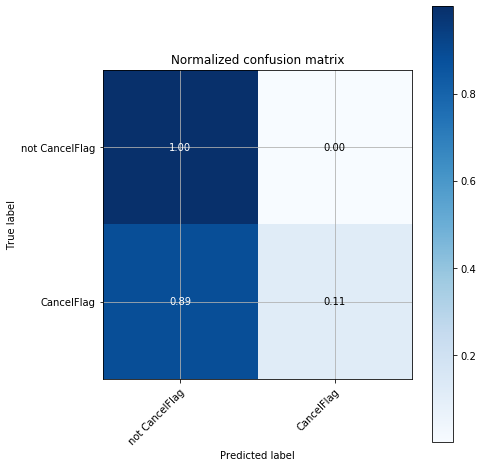


[Sat Nov 23 12:55:58 2019] Fold: 6/7
Train & val shapes - 304159 50692
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[358]	training's auc: 0.849529	valid_1's auc: 0.835243

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     47296
           1       0.98      0.09      0.17      3396

    accuracy                           0.94     50692
   macro avg       0.96      0.55      0.57     50692
weighted avg       0.94      0.94      0.91     50692



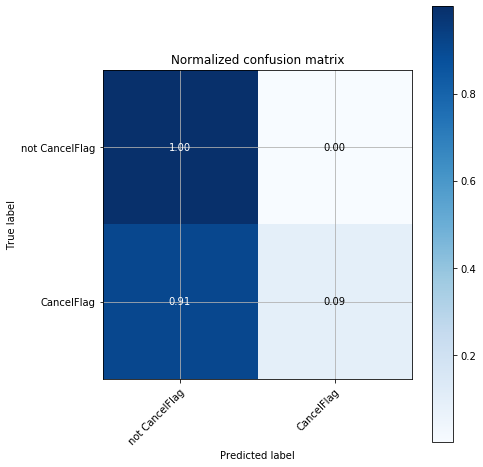


[Sat Nov 23 12:56:36 2019] Fold: 7/7
Train & val shapes - 304159 50692
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.883393	valid_1's auc: 0.857238
[2000]	training's auc: 0.903514	valid_1's auc: 0.867569
[3000]	training's auc: 0.916963	valid_1's auc: 0.871486
[4000]	training's auc: 0.927165	valid_1's auc: 0.873577
[5000]	training's auc: 0.935369	valid_1's auc: 0.874725
[6000]	training's auc: 0.942313	valid_1's auc: 0.875576
[7000]	training's auc: 0.94867	valid_1's auc: 0.875994
[8000]	training's auc: 0.9541	valid_1's auc: 0.875984
Early stopping, best iteration is:
[7503]	training's auc: 0.951541	valid_1's auc: 0.876118

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     47296
           1       0.65      0.33      0.44      3396

    accuracy                           0.94     50692
   macro avg       0.80      0.66      0.71     50692
weighted avg       0.93      0.94      0.93     50692



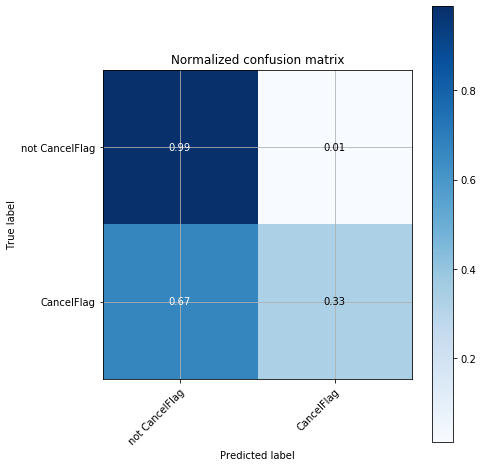


Folds score - 0.870841 +- 0.021071

CPU times: user 4h 56min 59s, sys: 2min 51s, total: 4h 59min 51s
Wall time: 25min 36s


In [11]:
%%time

test_dframe, oof_preds, fi = make_predictions(
    folds, 
    train_df,
    test_df,
    params,
    features=features2use,
    target=target,
    n_jobs=os.cpu_count(), 
    verbose=1_000, 
    early_stopping_rounds=500
)

In [12]:
fi = fi.sort_values(by='importance', ascending=False)

In [13]:
fi[fi['importance'] == 0]

,feature,importance
58,MaterialsCnt,0.0
21,PrevNumMaterialsByMonth|mean,0.0
59,MaterialsCnt|min,0.0
60,MaterialsCnt|max,0.0
61,MaterialsCnt|mean,0.0
62,MaterialsCnt|std,0.0
31,DiffWithPrevNumUniqueMaterialsByOrder|mean,0.0
20,NumMaterialsByMonth|mean,0.0
30,PrevNumUniqueMaterialsByOrder|mean,0.0
29,NumUniqueMaterialsByOrder|mean,0.0


In [14]:
fi[fi['importance'] == 0]['feature'].tolist()

['MaterialsCnt',
 'PrevNumMaterialsByMonth|mean',
 'MaterialsCnt|min',
 'MaterialsCnt|max',
 'MaterialsCnt|mean',
 'MaterialsCnt|std',
 'DiffWithPrevNumUniqueMaterialsByOrder|mean',
 'NumMaterialsByMonth|mean',
 'PrevNumUniqueMaterialsByOrder|mean',
 'NumUniqueMaterialsByOrder|mean',
 'NumGroupMaterialsByDay|mean',
 'DiffWithPrevNumMaterialsByMonth|mean',
 'DiffWithPrevNumGroupMaterialsByMonth|mean',
 'StartInterval_16',
 'Cluster_25',
 'Cluster_26',
 'Cluster_27',
 'Cluster_28',
 'Cluster_29',
 'NumGroupMaterialsByMonth|mean',
 'DiffWithPrevNumGroupMaterialsByDay|mean',
 'PrevNumGroupMaterialsByDay|mean',
 'PrevNumGroupMaterialsByMonth|mean']

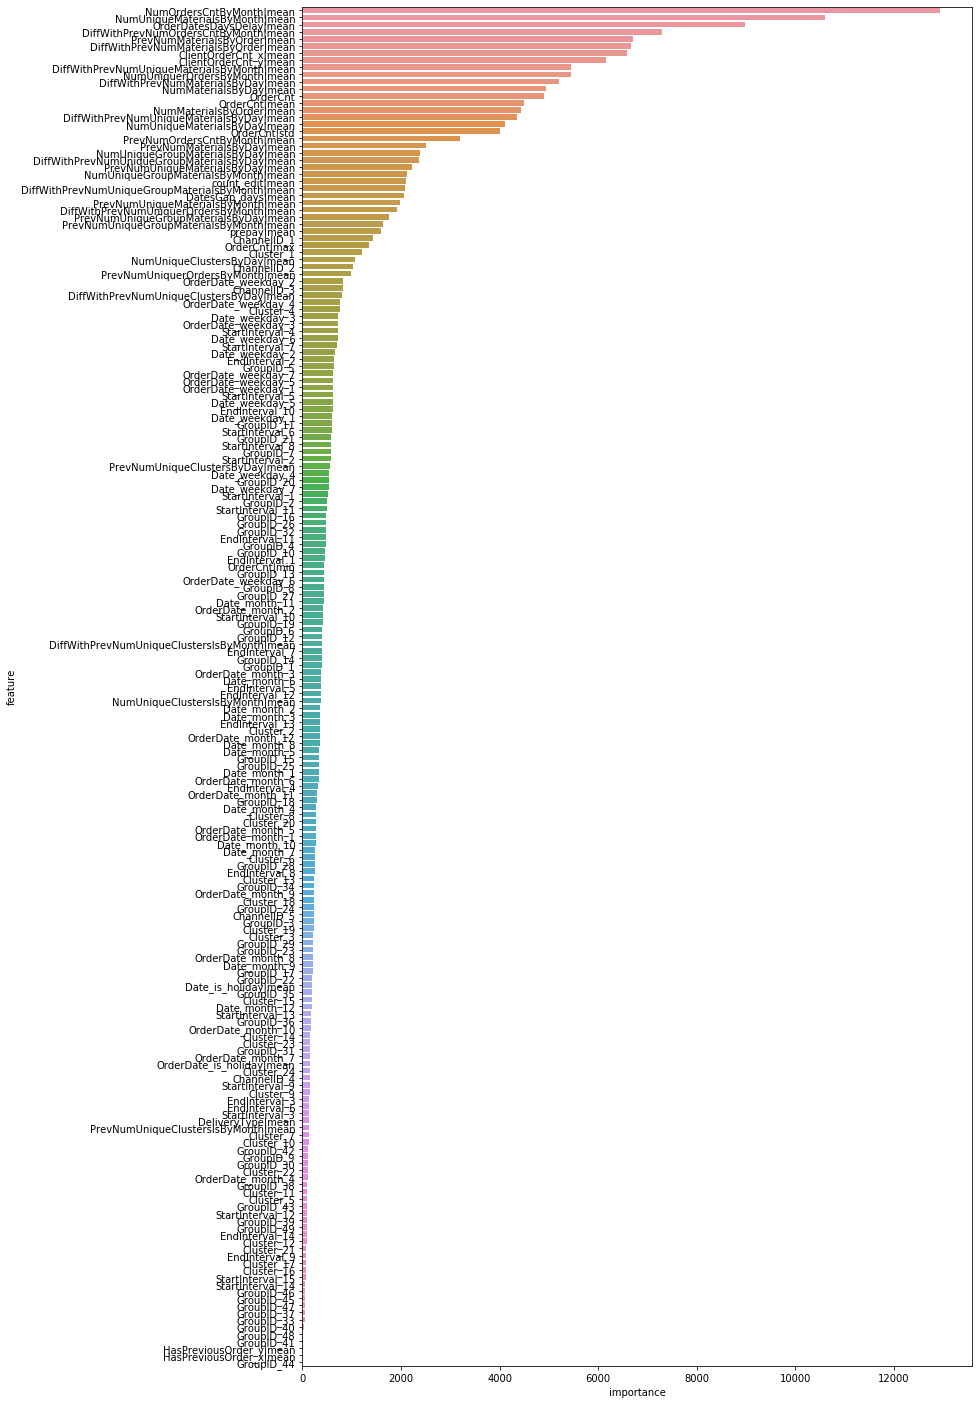

In [15]:
plt.figure(figsize=(12, 25))
sbn.barplot(x='importance', y='feature', data=fi[fi['importance'] > 0]);

In [16]:
fi.to_csv('feature_importance.csv', index=False)

In [17]:
t = test_df.copy()

res = t.groupby('OrderID').agg({'CancelFlag': 'mean'}).reset_index().rename(columns={'OrderID': 'ID', 'CancelFlag': 'Score'})
res['ID'] = res['ID'].map(lambda item: f'{item} ')
print(res.shape)
res.head()

(202614, 2)


,ID,Score
0,90102211131,0.072682
1,90102211133,0.023369
2,90102216055,0.177751
3,90102216081,0.147012
4,90102216084,0.121557


In [18]:
empty_df = ps.read_csv(data_folder / 'empty.csv')
print(empty_df.shape)
empty_df.head()

(202614, 2)


,ID,Score
0,90102211131,0.5
1,90102211133,0.5
2,90102216055,0.5
3,90102216081,0.5
4,90102216084,0.5


In [19]:
res.to_csv('../submission/lgbm_sub.csv', index=False)